In [1]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns

api = wandb.Api()


In [2]:
projects = api.projects(entity="haraghi")
for project in projects:
    print(project.name)

time_series_lstm_classification
FINAL-NASL-HP-sweep-reduced
FINAL-NCALTECH101-HP-sweep-reduced
FINAL-DVSGESTURE_TONIC-HP-sweep-reduced
FINAL-FAN1vs3-HP-sweep-reduced
FINAL-DVSGESTURE_TONIC-HP-varyinig-sparsity
FINAL-NCARS-varyinig-sparsity
FINAL-NASL-varyinig-sparsity
FINAL-NCALTECH101-varyinig-sparsity
FINAL-FAN1vs3-varyinig-sparsity
lightning_logs
FINAL-FAN1vs3-HP-sweep
EST-DVSGESTURE-HP-sweep-InMemory
EST-NASL-HP-sweep
EST-DVSGESTURE-HP-sweep
sweep_EST_NCALTECH101_HP_sweep
sweep_EST_FAN1VS3_25000_initialization_effect_multi20
sweep_EST_FAN1VS3_1024_initialization_effect_multi20
sweep_EST_NCALTECH101_25000_initialization_effect_multi20
sweep_EST_NCALTECH101_256_initialization_effect_multi20
sweep_EST_NCALTECH101_1024_multi20
sweep_EST_NCALTECH101_25000_multi20
sweep_EST_NCALTECH101_256_multi20
sweep_DGCNN_FAN1VS3_multi20
sweep EST (FAN1VS3) 25000 (multi val test num 20)
sweep EST (FAN1VS3) (multi val test num 20)
sweep EST (FAN1VS3)
DGCNN_CV_format
DGCNN
aegnn-ncaltech101-recognition

In [3]:
subfolder_name = 'HP_vs_acc'
dataset_name = 'NASL'
save_folder = os.path.join('images',subfolder_name,dataset_name)
save_folder_paper = os.path.join('images','paper',subfolder_name,dataset_name)

if dataset_name == 'DVSGESTURE_TONIC':
    # runs = api.runs("haraghi/EST-DVSGESTURE-HP-sweep")
    runs = api.runs("FINAL-DVSGESTURE_TONIC-HP-sweep-reduced")
elif dataset_name == 'FAN1VS3':
    # runs = list(api.runs("haraghi/sweep EST (FAN1VS3) (multi val test num 20)"))
    # runs += list(api.runs("haraghi/sweep EST (FAN1VS3) 25000 (multi val test num 20)"))
    runs = list(api.runs("FINAL-FAN1vs3-HP-sweep-reduced"))
elif dataset_name == 'NCALTECH101':
    runs = api.runs("FINAL-NCALTECH101-HP-sweep-reduced")
    # runs = list(api.runs("haraghi/sweep_EST_NCALTECH101_1024_multi20"))
    # runs += list(api.runs("haraghi/sweep_EST_NCALTECH101_25000_multi20"))
    # runs += list(api.runs("haraghi/sweep_EST_NCALTECH101_256_multi20"))  
elif dataset_name == 'NASL':
    # runs =api.runs("haraghi/EST-NASL-HP-sweep")
    runs =api.runs("FINAL-NASL-HP-sweep-reduced")
else:
    raise ValueError('Dataset name not recognized')

print(len(runs))

300


In [4]:
runs = [r for r in runs if r.state == "finished"]
print(len(runs))    

300


In [5]:
num_events = np.unique([run.config['transform']['train']['num_events_per_sample'] for run in runs])
print(num_events)
runs_per_num_events = {num_event: [run for run in runs if run.config['transform']['train']['num_events_per_sample'] == num_event] for num_event in num_events}

[    8 25000]


In [6]:
def find_val_and_test_acc_keys(run):
    val_acc_key = []
    test_acc_key = []
    for key in run.summary.keys():
        if "val" in key and "acc" in key and "mean" in key:
            val_acc_key.append(key)
        if "test" in key and "acc" in key and "mean" in key:
            test_acc_key.append(key)
    assert len(val_acc_key) <= 1, f"More than one val acc key found: {val_acc_key}"
    assert len(test_acc_key) <= 1, f"More than one test acc key found: {test_acc_key}"
    return val_acc_key[0] if len(val_acc_key) == 1 else None , test_acc_key[0] if len(test_acc_key) == 1 else None

In [7]:
val_mean = {}
test_mean = {}
lr = {}
batch_size = {}
weight_decay = {}
for num_event in num_events:
    val_mean[num_event] = []
    test_mean[num_event] = []
    lr[num_event] = []
    batch_size[num_event] = []
    weight_decay[num_event] = []
    for run in runs_per_num_events[num_event]:
        val_key, test_key = find_val_and_test_acc_keys(run)
        if val_key is None or test_key is None:
            continue
        val_mean[num_event].append(run.summary[val_key] if val_key in run.summary else None)
        test_mean[num_event].append(run.summary[test_key] if test_key in run.summary else None)
        lr[num_event].append(run.config['optimize']['lr'])
        batch_size[num_event].append(run.config['train']['batch_size'])
        if 'weight_decay' in run.config['optimize']:
            weight_decay[num_event].append(run.config['optimize']['weight_decay'])
    
for num_event in num_events:
    print(f"percentage of runs with val acc for {num_event} events: {np.sum([v is not None for v in val_mean[num_event]]) / len(val_mean[num_event])} out of {len(val_mean[num_event])} runs")
    print(f"percentage of runs with test acc for {num_event} events: {np.sum([v is not None for v in test_mean[num_event]]) / len(test_mean[num_event])} out of {len(test_mean[num_event])} runs")

percentage of runs with val acc for 8 events: 1.0 out of 149 runs
percentage of runs with test acc for 8 events: 1.0 out of 149 runs
percentage of runs with val acc for 25000 events: 1.0 out of 149 runs
percentage of runs with test acc for 25000 events: 1.0 out of 149 runs


In [8]:
print(len([l for l in lr[num_event] if l is not None]))
print(len([tm for tm in test_mean[num_event] if tm is not None]))

149
149


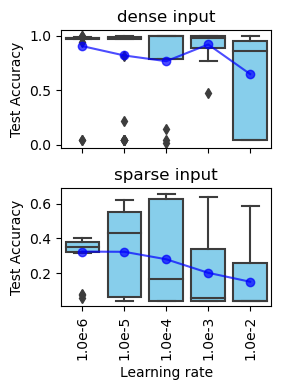

In [9]:
num_events_paper = [np.max(num_events), np.min(num_events)]

input_case = [ "dense", "sparse"]
# Create a figure with two subplots
fig, ax = plt.subplots(2, 1, figsize=(3, 4))

for i, num_event in enumerate(num_events_paper):
    
    # Create a DataFrame from the data  
    data = pd.DataFrame({'Learning Rate': [l for l in lr[num_event] if l is not None], 'Accuracy': [tm for tm in test_mean[num_event] if tm is not None]})
    mean_accuracy = data.groupby('Learning Rate')['Accuracy'].mean().reset_index()
    sns.boxplot(x='Learning Rate', y='Accuracy', data=data, ax=ax[i], boxprops=dict(facecolor="skyblue"))
    ax[i].set_title(f'{input_case[i]} input')
    # if i == 0:
        # ax[i].set_xticks([])
        # ax[i].set_xlabel()
        # for minor ticks
        # ax[i].set_xticks([], minor=True)
    
    ax[i].set_xlabel('Learning rate')
    # Modify the y-axis tick labels to scientific notation
    # ax[i].tick_params(axis='y', rotation=90)
    # ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
    ax[i].set_xticklabels(["{:.1e}".format(float(lr.get_text())).replace("e-0","e-") for lr in ax[i].get_xticklabels()], rotation=90)

    if i == 0:  
        ax[i].tick_params(labelbottom=False) 
        ax[i].set_xlabel('')
    ax[i].set_ylabel('Test Accuracy')
    ax[i].plot(mean_accuracy['Accuracy'].values, marker='o', color='blue', label='Test Mean Accuracy', alpha=0.7)
    # ax[i].legend()

# fig.suptitle(f'Learning rate: {num_event} events per sample for {len(val_mean[num_event])} runs')
plt.tight_layout()
if not os.path.exists(save_folder_paper):
    os.makedirs(save_folder_paper)
plt.savefig(os.path.join(save_folder_paper, f'lr_{dataset_name}_events_per_sample.png'))    
plt.show()


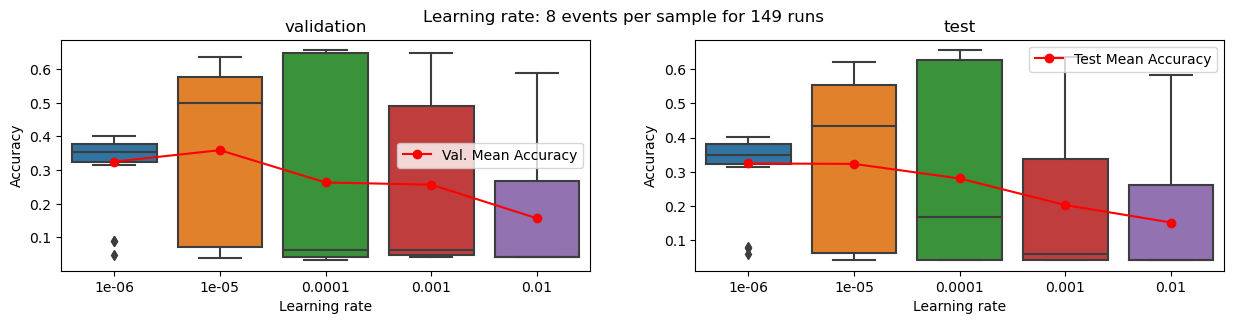

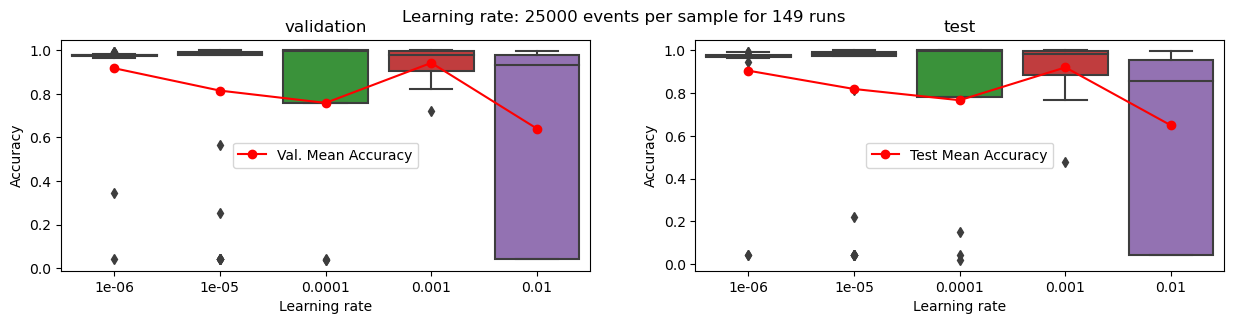

In [10]:
for num_event in num_events:
    fig,ax = plt.subplots(1,2, figsize=(15,3))
    
    
    # Create a DataFrame from the data
    data = pd.DataFrame({'Learning Rate': [l for l in lr[num_event] if l is not None], 'Accuracy': [vm for vm in val_mean[num_event] if vm is not None]})
    mean_accuracy = data.groupby('Learning Rate')['Accuracy'].mean().reset_index()
    sns.boxplot(x='Learning Rate', y='Accuracy', data=data, ax=ax[0])
    ax[0].set_title(f'validation')
    ax[0].set_xlabel('Learning rate')
    ax[0].set_ylabel('Accuracy')
    ax[0].plot(mean_accuracy['Accuracy'].values, marker='o', color='red', label='Val. Mean Accuracy')
    ax[0].legend()
    
    data = pd.DataFrame({'Learning Rate': [l for l in lr[num_event] if l is not None], 'Accuracy': [tm for tm in test_mean[num_event] if tm is not None]})
    mean_accuracy = data.groupby('Learning Rate')['Accuracy'].mean().reset_index()
    sns.boxplot(x='Learning Rate', y='Accuracy', data=data, ax=ax[1])
    ax[1].set_title(f'test')
    ax[1].set_xlabel('Learning rate')
    ax[1].set_ylabel('Accuracy')
    ax[1].plot(mean_accuracy['Accuracy'].values, marker='o', color='red', label='Test Mean Accuracy')
    ax[1].legend()
    
    fig.suptitle(f'Learning rate: {num_event} events per sample for {len(val_mean[num_event])} runs')
    
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    plt.savefig(os.path.join(save_folder, f'lr_{num_event}_events_per_sample.png'))    
    plt.show()

    

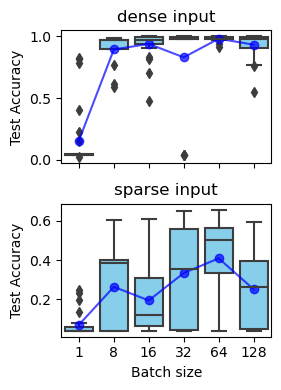

In [11]:
num_events_paper = [np.max(num_events), np.min(num_events)]

input_case = [ "dense", "sparse"]
# Create a figure with two subplots
fig, ax = plt.subplots(2, 1, figsize=(3, 4))

for i, num_event in enumerate(num_events_paper):
    
    # Create a DataFrame from the data  
    data = pd.DataFrame({'Batch size': [l for l in batch_size[num_event] if l is not None], 'Accuracy': [tm for tm in test_mean[num_event] if tm is not None]})
    mean_accuracy = data.groupby('Batch size')['Accuracy'].mean().reset_index()
    sns.boxplot(x='Batch size', y='Accuracy', data=data, ax=ax[i], boxprops=dict(facecolor="skyblue"))
    ax[i].set_title(f'{input_case[i]} input')
    ax[i].set_xlabel('Batch size')
    ax[i].set_ylabel('Test Accuracy')
    
    # Modify the y-axis tick labels to scientific notation
    # ax[i].tick_params(axis='y', rotation=90)
    # ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
    # ax[i].set_xticklabels(["{:.1e}".format(float(lr.get_text())).replace("e-0","e-") for lr in ax[i].get_xticklabels()], rotation=90)

    if i == 0:  
        ax[i].tick_params(labelbottom=False) 
        ax[i].set_xlabel('')
    ax[i].set_ylabel('Test Accuracy')
    ax[i].plot(mean_accuracy['Accuracy'].values, marker='o', color='blue', label='Test Mean Accuracy', alpha=0.7)
    # ax[i].legend()

# fig.suptitle(f'Learning rate: {num_event} events per sample for {len(val_mean[num_event])} runs')
plt.tight_layout()
if not os.path.exists(save_folder_paper):
    os.makedirs(save_folder_paper)
plt.savefig(os.path.join(save_folder_paper, f'BS_{dataset_name}_events_per_sample.png'))    
plt.show()

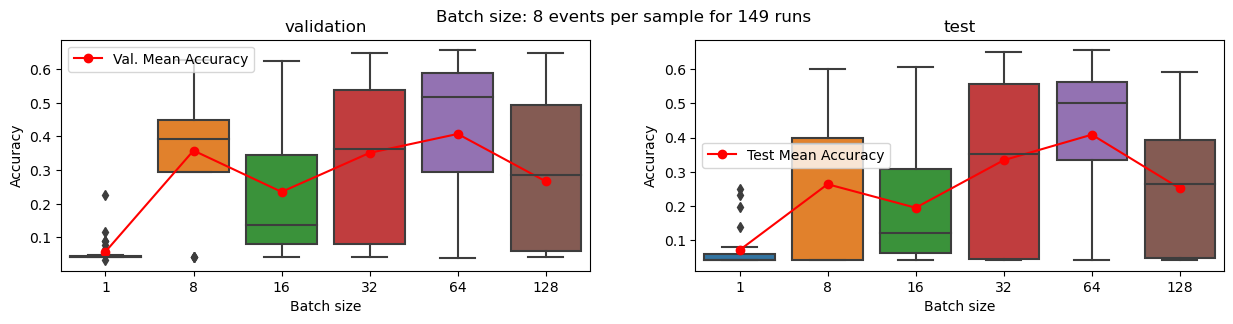

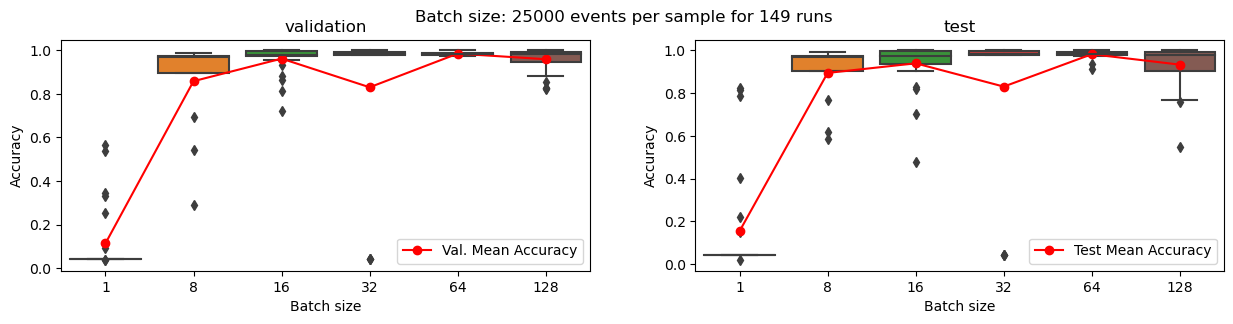

In [12]:
for num_event in num_events:
    fig,ax = plt.subplots(1,2, figsize=(15,3))
    
    
    # Create a DataFrame from the data
    data = pd.DataFrame({'Batch size': [l for l in batch_size[num_event] if l is not None], 'Accuracy': [vm for vm in val_mean[num_event] if vm is not None]})
    mean_accuracy = data.groupby('Batch size')['Accuracy'].mean().reset_index()
    sns.boxplot(x='Batch size', y='Accuracy', data=data, ax=ax[0])
    ax[0].set_title(f'validation')
    ax[0].set_xlabel('Batch size')
    ax[0].set_ylabel('Accuracy')
    ax[0].plot(mean_accuracy['Accuracy'].values, marker='o', color='red', label='Val. Mean Accuracy')
    ax[0].legend()
    
    data = pd.DataFrame({'Batch size': [l for l in batch_size[num_event] if l is not None], 'Accuracy': [tm for tm in test_mean[num_event] if tm is not None]})
    mean_accuracy = data.groupby('Batch size')['Accuracy'].mean().reset_index()
    sns.boxplot(x='Batch size', y='Accuracy', data=data, ax=ax[1])
    ax[1].set_title(f'test')
    ax[1].set_xlabel('Batch size')
    ax[1].set_ylabel('Accuracy')
    ax[1].plot(mean_accuracy['Accuracy'].values, marker='o', color='red', label='Test Mean Accuracy')
    ax[1].legend()
    
    fig.suptitle(f'Batch size: {num_event} events per sample for {len(val_mean[num_event])} runs')
    
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    plt.savefig(os.path.join(save_folder, f'batch_size_{num_event}_events_per_sample.png'))    
    plt.show()


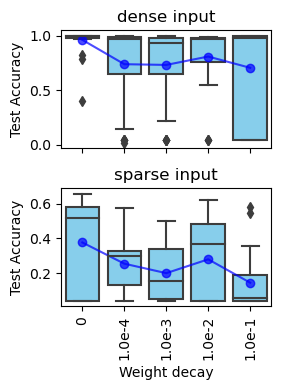

In [13]:
num_events_paper = [np.max(num_events), np.min(num_events)]

input_case = [ "dense", "sparse"]
# Create a figure with two subplots
fig, ax = plt.subplots(2, 1, figsize=(3, 4))

for i, num_event in enumerate(num_events_paper):
    
    
        
    data = pd.DataFrame({'Weight decay': [l for l in weight_decay[num_event] if l is not None], 'Accuracy': [tm for tm in test_mean[num_event] if tm is not None]})
    mean_accuracy = data.groupby('Weight decay')['Accuracy'].mean().reset_index()
    sns.boxplot(x='Weight decay', y='Accuracy', data=data, ax=ax[i], boxprops=dict(facecolor="skyblue"))
    ax[i].set_title(f'{input_case[i]} input')
    ax[i].set_xlabel('Weight decay')
    ax[i].set_ylabel('Test Accuracy')
    # ax[i].plot(mean_accuracy['Accuracy'].values, marker='o', color='red', label='Test Mean Accuracy')
    
    # Modify the y-axis tick labels to scientific notation
    # ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
    xticklabels = []
    for lr in ax[i].get_xticklabels():
        label_value = float(lr.get_text())
        if label_value == 0:
            xticklabels.append('0')
        else:
            xticklabels.append("{:.1e}".format(label_value).replace("e-0","e-"))
    ax[i].set_xticklabels(xticklabels, rotation=90)

    if i == 0:  
        ax[i].tick_params(labelbottom=False) 
        ax[i].set_xlabel('')
    ax[i].set_ylabel('Test Accuracy')
    ax[i].plot(mean_accuracy['Accuracy'].values, marker='o', color='blue', label='Test Mean Accuracy', alpha=0.7)
    # ax[i].legend()

# fig.suptitle(f'Learning rate: {num_event} events per sample for {len(val_mean[num_event])} runs')
plt.tight_layout()
if not os.path.exists(save_folder_paper):
    os.makedirs(save_folder_paper)
plt.savefig(os.path.join(save_folder_paper, f'WD_{dataset_name}_events_per_sample.png'))    
plt.show()

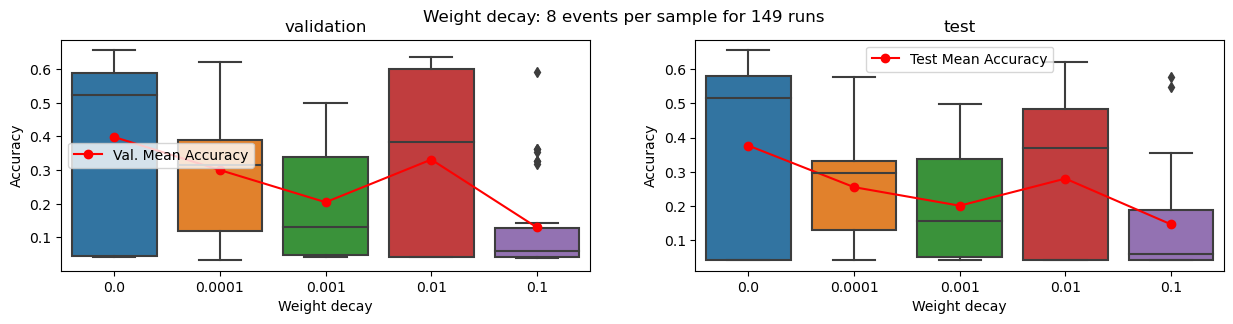

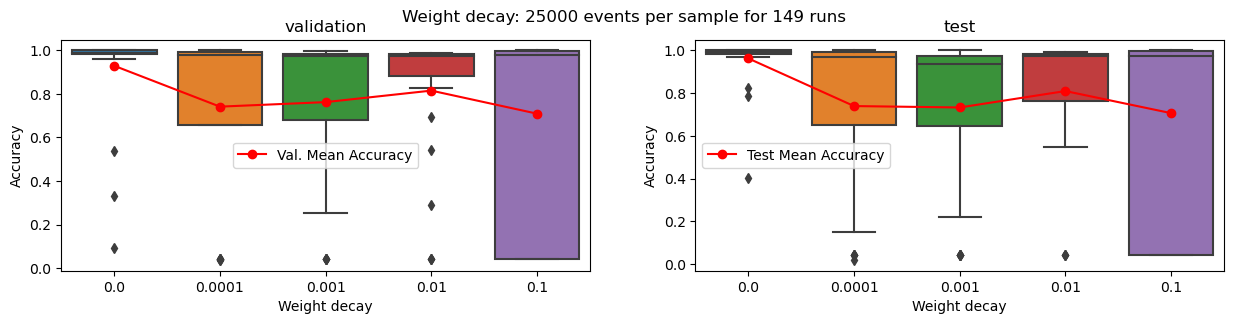

In [14]:
for num_event in num_events:
    fig,ax = plt.subplots(1,2, figsize=(15,3))
    
    
    # Create a DataFrame from the data
    data = pd.DataFrame({'Weight decay': [l for l in weight_decay[num_event] if l is not None], 'Accuracy': [vm for vm in val_mean[num_event] if vm is not None]})
    mean_accuracy = data.groupby('Weight decay')['Accuracy'].mean().reset_index()
    sns.boxplot(x='Weight decay', y='Accuracy', data=data, ax=ax[0])
    ax[0].set_title(f'validation')
    ax[0].set_xlabel('Weight decay')
    ax[0].set_ylabel('Accuracy')
    ax[0].plot(mean_accuracy['Accuracy'].values, marker='o', color='red', label='Val. Mean Accuracy')
    ax[0].legend()
    
    data = pd.DataFrame({'Weight decay': [l for l in weight_decay[num_event] if l is not None], 'Accuracy': [tm for tm in test_mean[num_event] if tm is not None]})
    mean_accuracy = data.groupby('Weight decay')['Accuracy'].mean().reset_index()
    sns.boxplot(x='Weight decay', y='Accuracy', data=data, ax=ax[1])
    ax[1].set_title(f'test')
    ax[1].set_xlabel('Weight decay')
    ax[1].set_ylabel('Accuracy')
    ax[1].plot(mean_accuracy['Accuracy'].values, marker='o', color='red', label='Test Mean Accuracy')
    ax[1].legend()
    
    fig.suptitle(f'Weight decay: {num_event} events per sample for {len(val_mean[num_event])} runs')
    
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    plt.savefig(os.path.join(save_folder, f'weight_decay_{num_event}_events_per_sample.png'))    
    plt.show()